In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('../data/mvp_data.csv', parse_dates=True, index_col=0)
df.columns = ['EUR', 'GOLD', 'Bitcoin', 'Apple', 'Exxon', 'VISA', 'Oil']
# заполним пропуски последними известными значениями, так как пропуски чаще всего - это праздничные периоды
# перейдем на недельный интервал и средним значениям на них
df_w = df.fillna(method='ffill').resample('W').ffill()
df_w_pct = df_w.pct_change().iloc[1:] # отнсительные изменения к предыдущей неделе
df_w_log = np.log(df_w/df_w.shift(1)).iloc[1:] # переходим к логдоходности
df_w_log.head()

,EUR,GOLD,Bitcoin,Apple,Exxon,VISA,Oil
Date,,,,,,,
2020-01-12,-0.005415,0.005343,0.106043,0.042457,-0.017065,0.021755,-0.065713
2020-01-19,0.002559,0.000834,0.089262,0.026708,-0.008424,0.054873,-0.008505
2020-01-26,-0.007602,0.007860,-0.055683,-0.001319,-0.033218,0.001465,-0.077214
2020-02-02,-0.002363,0.007483,0.101807,-0.028035,-0.065424,-0.029856,-0.049750
2020-02-09,-0.004193,-0.009075,0.046535,0.035795,-0.010519,0.018770,-0.024344


In [10]:
train_df = df_w_log[:'2021-12-31'] # TRAIN 2020-2021
test_df = df_w_log['2022-01-01':] # TEST 2022

In [40]:
assetsNum = len(df.columns)
period_ret = 52 # для перехода от недельной к годовой доходности
iterNum = 10000

all_portf = np.zeros((iterNum, assetsNum)) # все портфели
ret_arr = np.zeros(iterNum) # доходность
vol_arr = np.zeros(iterNum) # волатильность для оценки риска
sharpe_arr = np.zeros(iterNum)

for x in range(iterNum):
    portf = np.array(np.random.random(assetsNum))
    portf = portf/np.sum(portf)
    
    all_portf[x,:] = portf
    
    ret_arr[x] = np.sum((train_df.mean()*portf*period_ret))
    
    vol_arr[x] = np.sqrt(np.dot(portf.T, np.dot(train_df.cov()*period_ret, portf)))
    
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [41]:
max_sharpe_portf = sharpe_arr.argmax()
max_sharpe_ret = ret_arr[sharpe_arr.argmax()]
max_sharpe_vol = vol_arr[sharpe_arr.argmax()]

print(sharpe_arr.max())
print(max_sharpe_portf)
print(all_portf[max_sharpe_portf, :])

1.5894181631127404
6879
[0.11960999 0.09553068 0.31381035 0.40588384 0.01563778 0.02500876
 0.0245186 ]


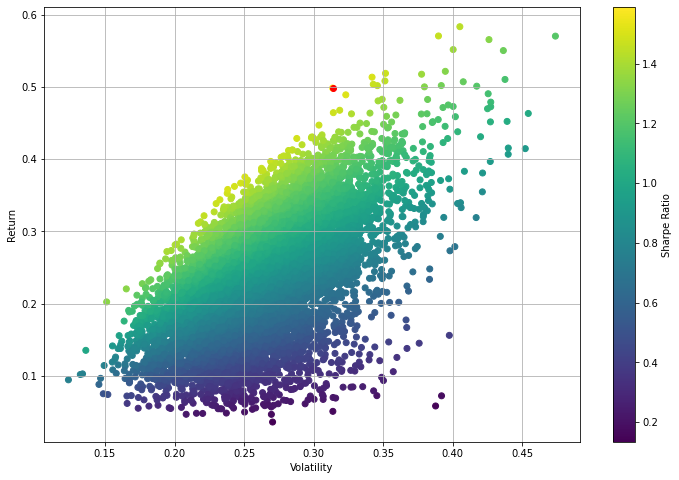

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='red')
plt.grid()
plt.show()

In [45]:
# возвращает прибыль, волатильность и коэффициент Шарпа для любого портфеля
def get_params(portf):
    portf = np.array(portf)
    ret = np.sum(df_w_log.mean() * portf) * period_ret
    vol = np.sqrt(np.dot(portf.T, np.dot(df_w_log.cov()*period_ret, portf)))
    shrp = ret/vol
    return np.array([ret, vol, shrp])

# вовзращает отрицательный кэф. Шарпа
def neg_sharpe(portf):
    return get_params(portf)[2] * -1

# проверка на валидность: возвращает 0, если сумма равна 1
def check_valid(portf):
    return np.sum(portf) - 1

In [57]:
cons = ({'type': 'eq', 'fun': check_valid})
bounds = tuple([(0, 1) for _ in range(assetsNum)])
init_portf = [1/assetsNum for _ in range(assetsNum)]


In [63]:
# поиск оптимального портфеля с помощью МНК
from scipy.optimize import minimize
res = minimize(neg_sharpe, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
print(res)

     fun: -0.7263818464707447
     jac: array([ 1.54389791e-01,  3.99500132e-05, -6.08116388e-05,  3.66866589e-05,
       -7.18981028e-05,  4.29453090e-01,  4.52182531e-01])
 message: 'Optimization terminated successfully'
    nfev: 57
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.        , 0.1977801 , 0.07401672, 0.45088955, 0.27731363,
       0.        , 0.        ])


In [64]:
get_params(res.x)

array([0.17551164, 0.24162448, 0.72638185])

## Визуализация границ

In [65]:
frontier_y = np.linspace(0, 0.6, 200)

In [67]:
def minimize_vol(portf):
    return get_params(portf)[1]

In [68]:
frontier_x = []

for y in frontier_y:
    cons = ({'type':'eq', 'fun':check_valid},
            {'type':'eq', 'fun': lambda w: get_params(w)[0] - y})
    
    result = minimize(minimize_vol, init_portf, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

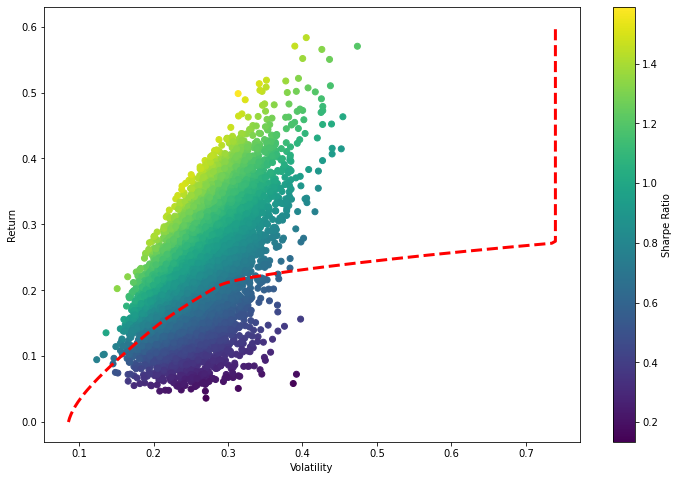

In [69]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
plt.show()

### Какая-то бяка... тут надо поработать еще с визуализацией границы, само облако портфелей рисуется нормально

## Динамика по портфелю + тестирование

In [82]:
train_din = np.matmul(df_w_pct[:'2021-12-31'], res.x).cumsum() # TRAIN 2020-2021
test_din = np.matmul(df_w_pct['2022-01-01':], res.x).cumsum() # TEST 2022

<AxesSubplot:xlabel='Date'>

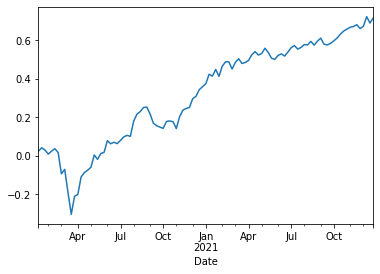

In [83]:
train_din.plot()

<AxesSubplot:xlabel='Date'>

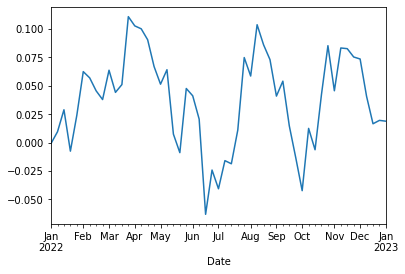

In [84]:
test_din.plot()